In [1]:
#imports
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegressionCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler

## Load and Normalize Data

In [2]:
#Load Data
merged_data_clean_relevant = pd.read_csv("../Behavioural_Data_MPILMBB_LEMON/merged_data_clean_relevant.csv")
relationship_status = pd.read_csv("../Behavioural_Data_MPILMBB_LEMON/relationship_status.csv")

print(relationship_status.sum())
print(merged_data_clean_relevant)

Relationship_Status    156
dtype: int64
     LPS_1  TAP_WM_1  TAP_WM_6  CERQ_SelfBlame  CERQ_Acceptance  \
0       27     613.0        15        2.333333         1.666667   
1       24     693.0        13        1.666667         2.666667   
2       25     551.0        15        2.000000         2.666667   
3       17     705.0        14        2.000000         1.666667   
4       20     509.0         8        1.666667         3.333333   
..     ...       ...       ...             ...              ...   
219     23     420.0        13        2.000000         2.000000   
220     23     420.0        13        2.000000         2.000000   
221     23     420.0        13        2.000000         2.000000   
222     23     420.0        13        2.000000         2.000000   
223     20     585.0        15        2.000000         2.666667   

     CERQ_Rumination  CERQ_positiveRefocusing  CERQ_RefocusOnPlanning  \
0           2.000000                 1.000000                1.333333   
1        

In [3]:
#normalize data
scaler = RobustScaler()
merged_data_clean_scaled = scaler.fit_transform(merged_data_clean_relevant)

#Dataframe with normalized columsn and header
merged_data_clean_scaled_dataframe = pd.DataFrame(merged_data_clean_scaled, columns=merged_data_clean_relevant.columns)

## Training

In [4]:
relationship_array = relationship_status["Relationship_Status"]

In [5]:
X_train = merged_data_clean_scaled
Y_train = relationship_array #0 oder 1

### Logistic Regression

In [13]:
#set up learning function 
#set up cross validation. 
# Train

# set hyperparameters
n_folds = 10
n_alphas = 10
max_iter = 5000

# define models
ridge_model = LogisticRegressionCV(penalty="l2", n_jobs = 16, max_iter=max_iter, fit_intercept=False, random_state=1, solver='saga', cv=n_folds, Cs=n_alphas)

# INSERT YOUR CODE HERE
logreg_ridge_cv = ridge_model.fit(X_train, Y_train)

In [14]:
# Cross-validated accuracy scores for each fold
cv_scores = logreg_ridge_cv.scores_[1]  # For the positive class (1)

# Mean accuracy across folds
mean_cv_accuracy = cv_scores.mean()

# Print the cross-validated accuracy
print(f"Mean cross-validated accuracy: {mean_cv_accuracy:.4f}")

Mean cross-validated accuracy: 0.6471


## Random Forest

In [17]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],        # Number of trees in the forest
    'max_depth': [None, 5, 10, 15],       # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],      # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4], 
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(class_weight='balanced', random_state=42), #The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))
    param_grid=param_grid,
    cv=5,       # Cross-validation folds
    scoring='accuracy',
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_train, Y_train)

# Best Parameters
print("Best Parameters:", grid_search.best_params_)

# Use the best model for predictions
best_rf_model = grid_search.best_estimator_
y_pred = best_rf_model.predict(X_train)

# Evaluate the best model
print("Accuracy:", accuracy_score(Y_train, y_pred))


Best Parameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.9821428571428571


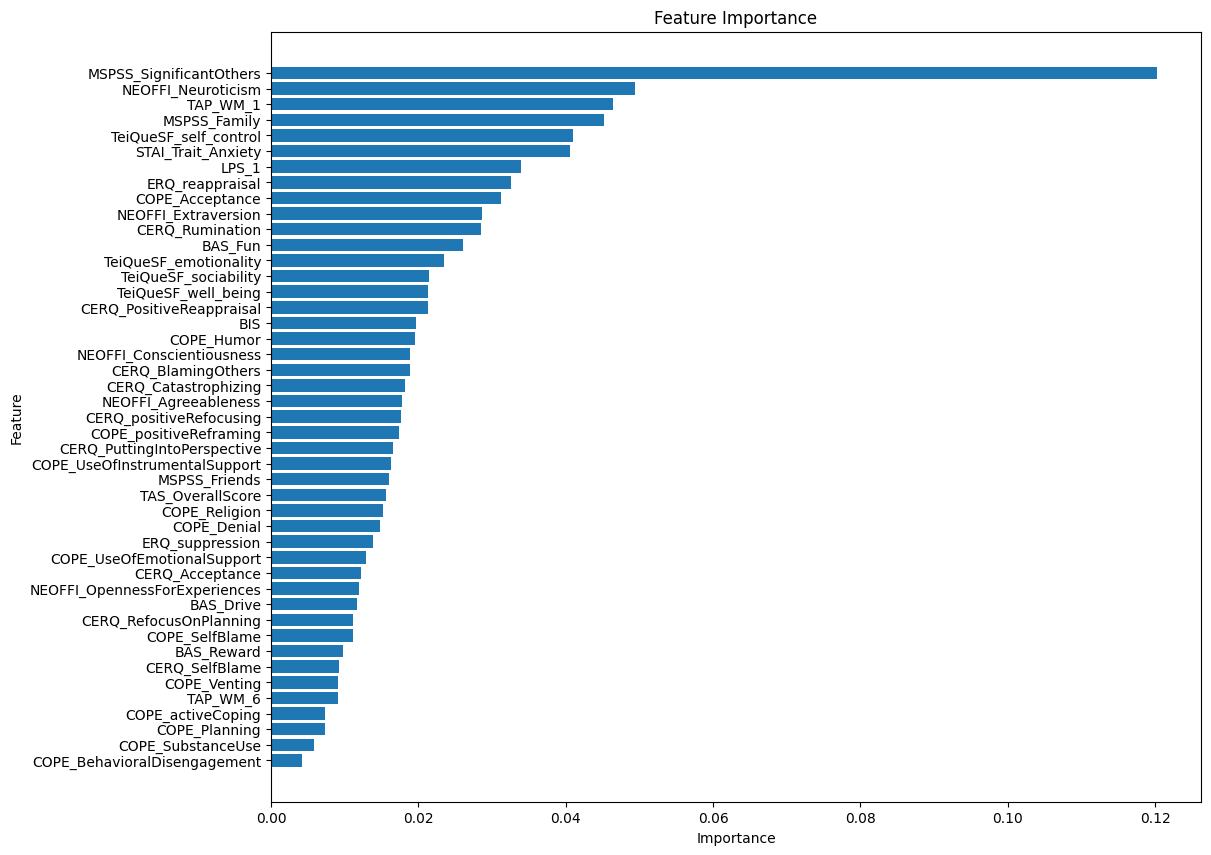

In [18]:
# Feature Importance
feature_importances = pd.DataFrame({
    'Feature': merged_data_clean_scaled_dataframe.columns,
    'Importance': best_rf_model.feature_importances_
}).sort_values(by='Importance', ascending=True)

# Plot
plt.figure(figsize=(12, 10))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Initialize the Random Forest Model
rf_model = RandomForestClassifier(
    n_estimators=100,     # Number of trees
    max_depth=5,       # Maximum depth of trees
    random_state=42,      # Ensures reproducibility
    n_jobs=-1,
    min_samples_leaf= 1,
    min_samples_split=2,
    class_weight='balanced'      #account for imbalanced dataset
)

# Set up Stratified Cross-Validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Perform Cross-Validation
cv_scores = cross_val_score(rf_model, X_train, Y_train, cv=cv, scoring='accuracy', n_jobs=-1)

# Print Cross-Validation Results
print("Cross-Validation Accuracy Scores:", cv_scores)
print(f"Mean Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


Cross-Validation Accuracy Scores: [0.86956522 0.65217391 0.7826087  0.65217391 0.68181818 0.72727273
 0.68181818 0.59090909 0.63636364 0.77272727]
Mean Accuracy: 0.7047 ± 0.0791


In [20]:
cm = confusion_matrix(Y_train, y_pred)

# Extract class-specific metrics
class_0_accuracy = cm[0, 0] / cm[0].sum()  # Accuracy for class 0
class_1_accuracy = cm[1, 1] / cm[1].sum()  # Accuracy for class 1

print(f"Accuracy for Class 0: {class_0_accuracy:.4f}")
print(f"Accuracy for Class 1: {class_1_accuracy:.4f}")

Accuracy for Class 0: 0.9559
Accuracy for Class 1: 0.9936
